In [3]:
import cv2
import numpy as np
import pytesseract
from docx import Document
from docx.oxml import parse_xml
from docx.oxml.ns import nsdecls
import os

# Đường dẫn tới folder chứa ảnh
image_folder = 'data'

# Tạo file Word mới để lưu kết quả từ nhiều ảnh
doc = Document()

# Duyệt qua tất cả các tệp trong folder
for filename in os.listdir(image_folder):
    if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
        image_path = os.path.join(image_folder, filename)

        # Bước 1: Đọc ảnh và tiền xử lý
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Áp dụng threshold để chuyển ảnh thành đen trắng
        _, binary_img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)

        # Bước 2: Tìm đường kẻ ngang và dọc để xác định bảng
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))  # Kernel cho đường ngang
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))   # Kernel cho đường dọc

        # Tìm các đường kẻ ngang và dọc
        horizontal_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
        vertical_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

        # Bước 3: Kết hợp các đường kẻ ngang và dọc để tạo ra vùng bảng
        table_area = cv2.add(horizontal_lines, vertical_lines)

        # Bước 4: Tìm các contours (đường viền) để phân chia bảng
        contours, _ = cv2.findContours(table_area, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Lưu trữ các bounding box của contours
        bounding_boxes = [cv2.boundingRect(c) for c in contours]

        # Thêm tiêu đề cho mỗi ảnh
        doc.add_heading(f'Kết quả cho ảnh: {filename}', level=1)

        # Kiểm tra xem có bảng hay không
        if bounding_boxes:
            # Loại bỏ contour lớn nhất (toàn bộ bảng lớn)
            max_contour = max(bounding_boxes, key=lambda b: b[2] * b[3])
            bounding_boxes = [b for b in bounding_boxes if b != max_contour]

            # Bước 5: Phủ đen vùng bảng trên ảnh sao chép để xử lý phần văn bản
            img_text_only = binary_img.copy()

            # Phủ đen các vùng bảng trên ảnh sao chép
            for x, y, w, h in bounding_boxes:
                cv2.rectangle(img_text_only, (x, y), (x + w, y + h), (0, 0, 0), -1)  # Phủ đen

            # Bước 6: OCR văn bản từ ảnh đã loại bỏ bảng
            text_from_image = pytesseract.image_to_string(img_text_only, lang='vie').strip()

            # Thêm nội dung đoạn văn vào file Word
            doc.add_paragraph(text_from_image)

            # Bước 7: OCR cho từng cell của bảng và lưu kết quả vào danh sách
            table_data = []
            for idx, (x, y, w, h) in enumerate(bounding_boxes):
                if w > 50 and h > 20:  # Điều chỉnh ngưỡng để bỏ qua các vùng quá nhỏ
                    cell_img = img[y:y+h, x:x+w]
                    
                    # OCR cho cell
                    text = pytesseract.image_to_string(cell_img).strip()
                    
                    # Thêm nội dung vào danh sách dữ liệu bảng
                    table_data.append((x, y, w, h, text))

            # Xác định số hàng và số cột dựa trên vị trí các ô
            rows = len(set([y for _, y, _, _, _ in table_data]))  # Số hàng dựa trên giá trị y
            cols = len(set([x for x, _, _, _, _ in table_data]))  # Số cột dựa trên giá trị x

            # Kiểm tra xem có hàng và cột không
            if rows > 0 and cols > 0:
                # Tạo bảng trong file Word
                table = doc.add_table(rows=rows, cols=cols)

                # Chèn nội dung vào các ô của bảng
                sorted_table_data = sorted(table_data, key=lambda t: (t[1], t[0]))  # Sắp xếp theo vị trí y (hàng), rồi đến x (cột)
                row_idx, col_idx = 0, 0
                prev_y = sorted_table_data[0][1]

                for idx, (x, y, w, h, text) in enumerate(sorted_table_data):
                    # Nếu y thay đổi (tức là sang hàng mới), tăng chỉ số hàng và đặt lại chỉ số cột
                    if y != prev_y:
                        row_idx += 1
                        col_idx = 0
                        prev_y = y
                    
                    # Chèn nội dung vào ô tương ứng
                    if row_idx < rows and col_idx < cols:
                        cell = table.cell(row_idx, col_idx)
                        cell.text = text
                        
                        # Thêm đường viền cho ô
                        cell._element.get_or_add_tcPr().append(parse_xml(r'<w:tcBorders {}>'
                                                                          r'<w:left w:val="single" w:sz="4" wspace="0" ws="0"/>' 
                                                                          r'<w:right w:val="single" w:sz="4" wspace="0" ws="0"/>' 
                                                                          r'<w:top w:val="single" w:sz="4" wspace="0" ws="0"/>' 
                                                                          r'<w:bottom w:val="single" w:sz="4" wspace="0" ws="0"/>' 
                                                                          r'</w:tcBorders>'.format(nsdecls('w'))))

                    col_idx += 1
        else:
            # Nếu không có bảng, chỉ OCR toàn bộ văn bản
            text_from_image = pytesseract.image_to_string(binary_img, lang='vie').strip()
            
            # Thêm nội dung đoạn văn vào file Word
            doc.add_paragraph(text_from_image)

# Lưu tài liệu thành file .doc
doc.save('output_with_folder.docx')
print("Đã lưu nội dung từ tất cả các ảnh trong folder vào file 'output_with_text_and_table_from_folder.docx'.")


Đã lưu nội dung từ tất cả các ảnh trong folder vào file 'output_with_text_and_table_from_folder.docx'.


Processing image: test\ta1.png


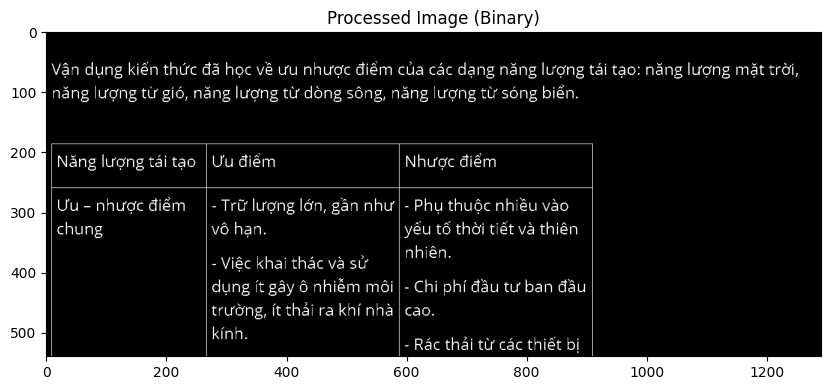

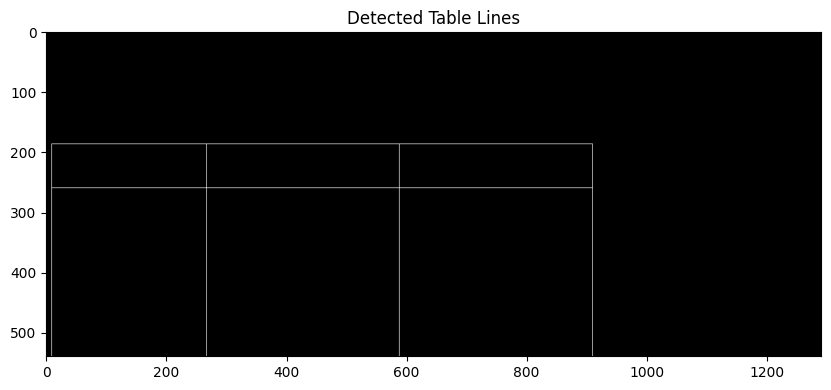

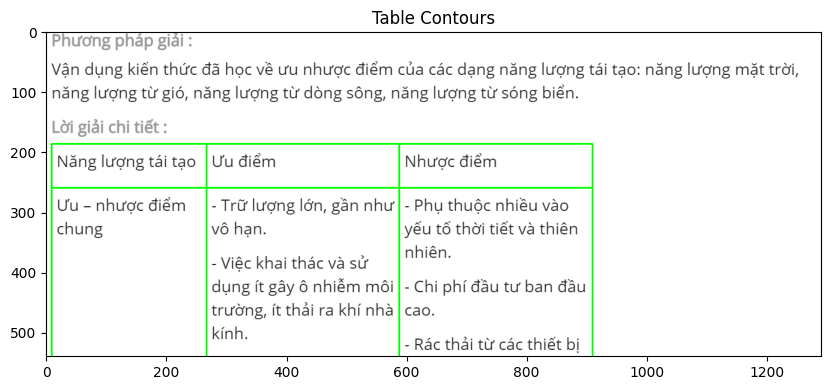

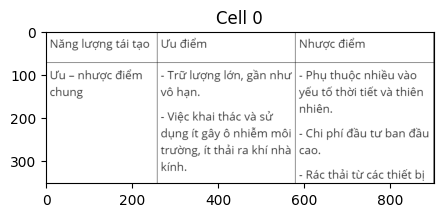

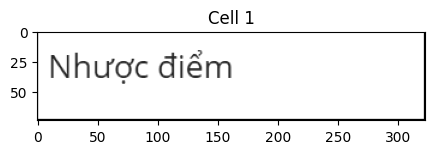

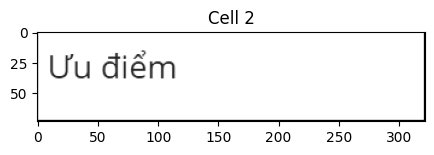

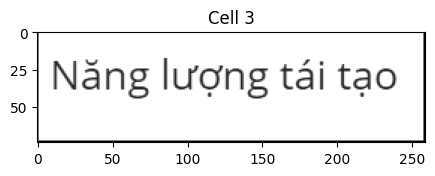

Processing image: test\tb2.png


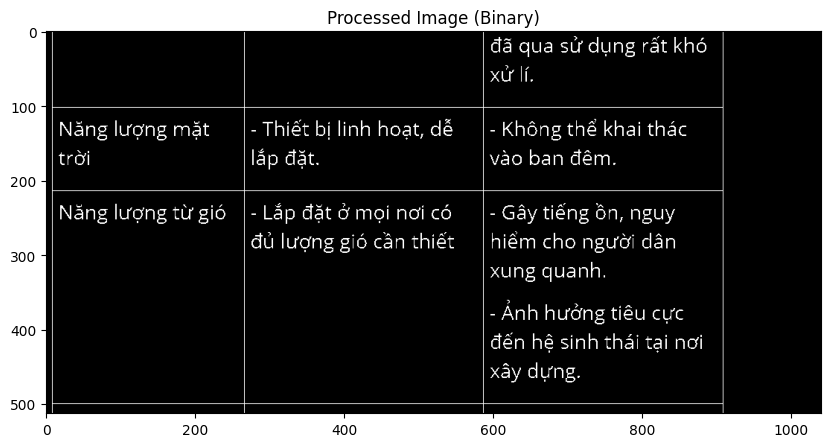

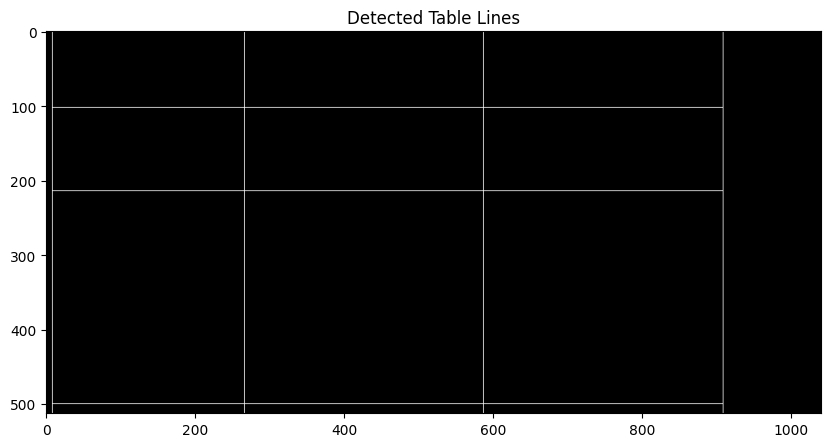

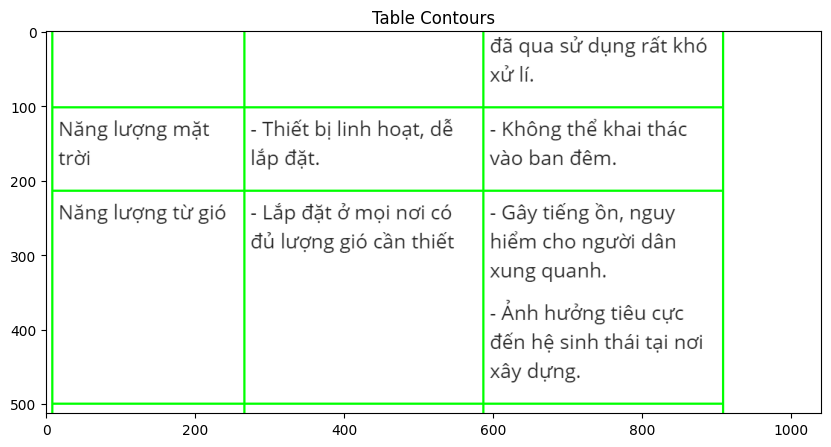

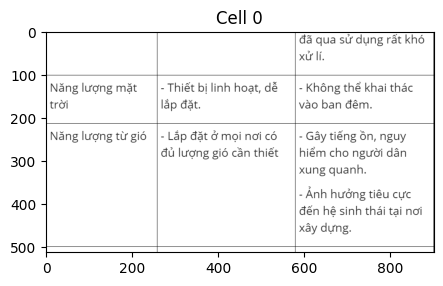

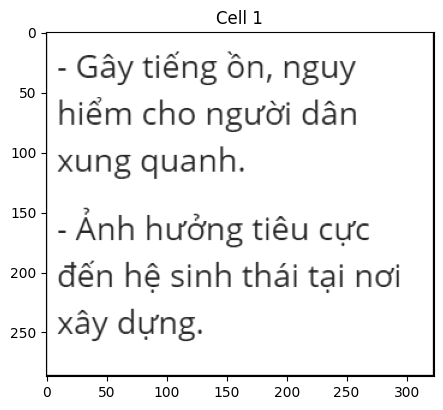

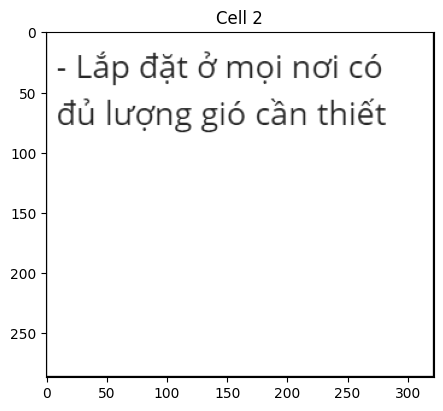

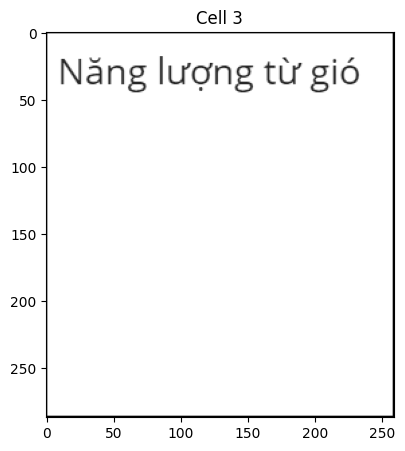

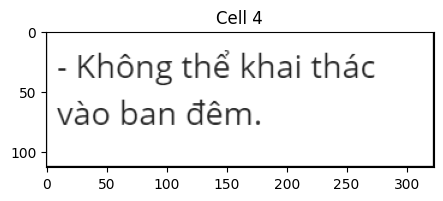

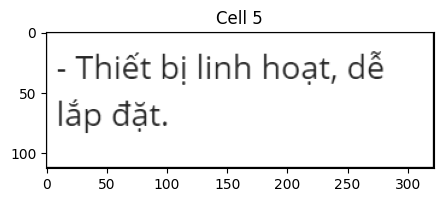

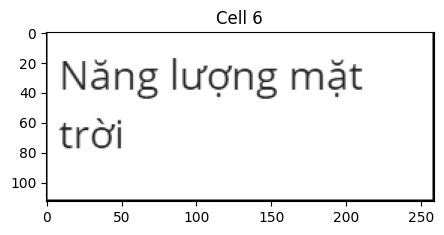

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def process_image(image_path):
    """Xử lý một ảnh để phát hiện bảng và các ô."""
    # Bước 1: Đọc ảnh và tiền xử lý
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Áp dụng threshold để chuyển ảnh thành đen trắng
    _, binary_img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)

    # Hiển thị ảnh sau tiền xử lý
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_img, cmap='gray')
    plt.title('Processed Image (Binary)')
    plt.show()

    # Bước 2: Tìm đường kẻ ngang và dọc
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))  # Kernel cho đường ngang
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))   # Kernel cho đường dọc

    # Tìm các đường kẻ ngang
    horizontal_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    # Tìm các đường kẻ dọc
    vertical_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    # Bước 3: Kết hợp các đường kẻ ngang và dọc
    table_area = cv2.add(horizontal_lines, vertical_lines)

    # Hiển thị vùng bảng đã phát hiện
    plt.figure(figsize=(10, 10))
    plt.imshow(table_area, cmap='gray')
    plt.title('Detected Table Lines')
    plt.show()

    # Bước 4: Tìm các contours (đường viền) để phân chia bảng
    contours, hierarchy = cv2.findContours(table_area, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Tạo một bản sao của ảnh gốc để vẽ các contours
    img_with_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Vẽ contours lên ảnh
    cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 2)

    # Hiển thị ảnh với contours
    plt.figure(figsize=(10, 10))
    plt.imshow(img_with_contours)
    plt.title('Table Contours')
    plt.show()

    # Bước 5: Chia ảnh thành các ô và hiển thị từng ô
    for idx, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        
        if w > 50 and h > 20:  # Điều chỉnh ngưỡng để bỏ qua các vùng quá nhỏ
            cell_img = img[y:y+h, x:x+w]
            
            # Hiển thị từng ô
            plt.figure(figsize=(5, 5))
            plt.imshow(cell_img, cmap='gray')
            plt.title(f'Cell {idx}')
            plt.show()

def process_images_in_folder(folder_path):
    """Xử lý tất cả ảnh trong thư mục."""
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Kiểm tra định dạng file
            image_path = os.path.join(folder_path, filename)
            print(f"Processing image: {image_path}")
            process_image(image_path)

# Đường dẫn đến thư mục chứa ảnh
image_folder = 'test'  # Thay đổi thành đường dẫn thư mục của bạn

process_images_in_folder(image_folder)


Processing image: test\ta1.png


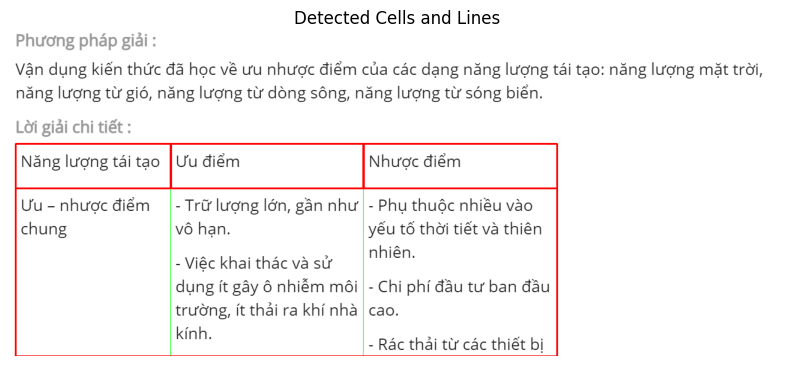

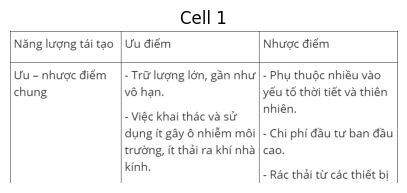

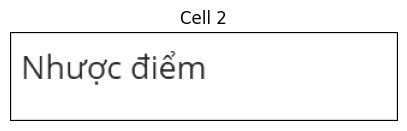

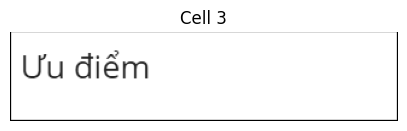

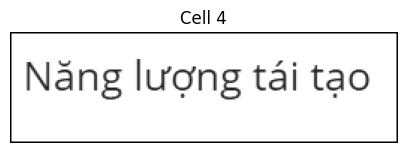

Processing image: test\tb2.png


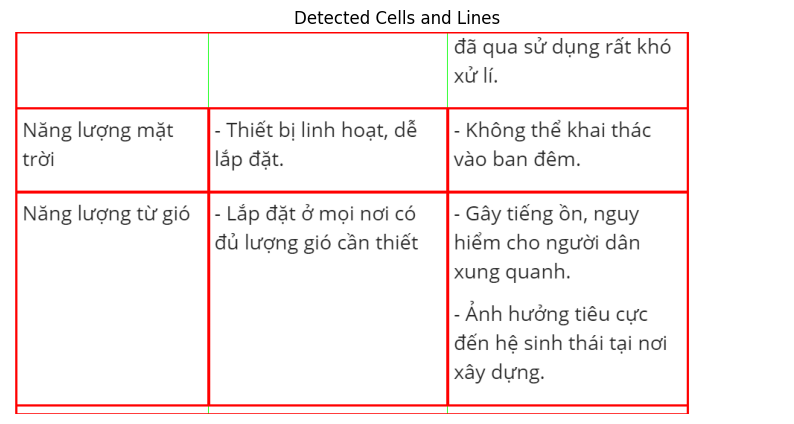

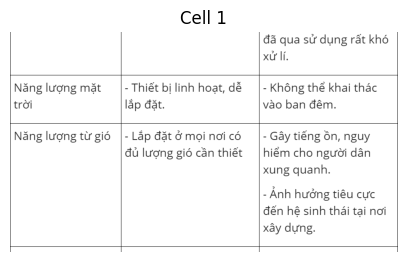

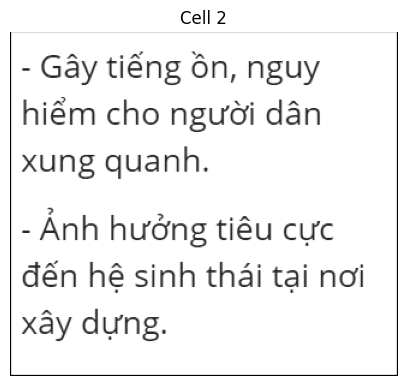

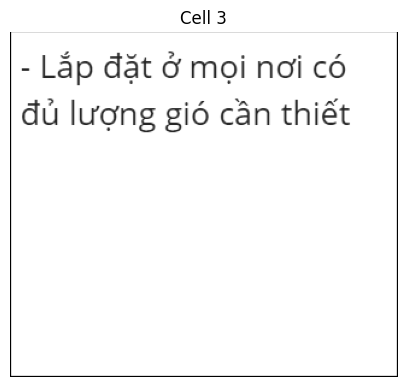

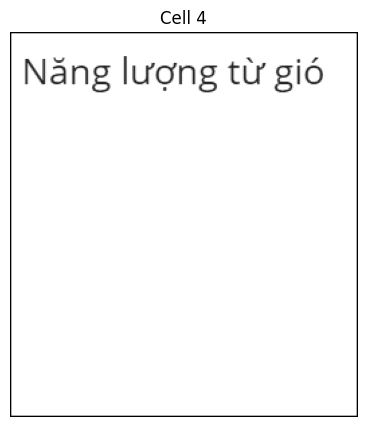

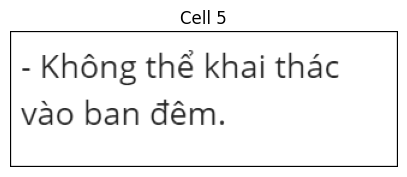

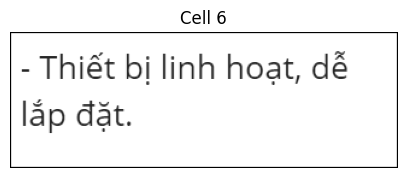

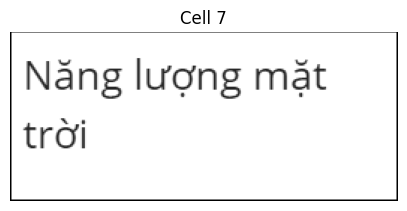

Cell information saved to cell_info.csv


In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def find_cells_in_image(image_path, previous_cells=[]):
    """Xử lý một ảnh để phát hiện ô và nối với ô trước đó nếu cần."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary_img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))

    horizontal_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    vertical_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    table_area = cv2.add(horizontal_lines, vertical_lines)
    contours, _ = cv2.findContours(table_area, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cells = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 50 and h > 20:
            cells.append((x, y, w, h))

    # Nối các ô với ô từ ảnh trước đó
    merged_cells = merge_cells(cells, previous_cells)

    # Hiển thị các ô tìm được và đường kẻ
    display_cells_and_lines(img, merged_cells, horizontal_lines, vertical_lines)

    # Hiển thị từng ô riêng biệt
    display_individual_cells(img, merged_cells)

    return merged_cells

def merge_cells(current_cells, previous_cells):
    """Nối các ô từ ảnh hiện tại với ô từ ảnh trước đó."""
    merged = []
    
    for current in current_cells:
        x, y, w, h = current
        
        # Kiểm tra xem nó có gần với ô nào trong previous_cells không
        for previous in previous_cells:
            px, py, pw, ph = previous
            
            # Điều kiện nối
            if abs(px - x) < 10 and abs(py - y) < 10:  # Điều chỉnh khoảng cách tùy ý
                # Nối ô
                new_cell = (min(x, px), min(y, py), max(x + w, px + pw) - min(x, px), max(y + h, py + ph) - min(y, py))
                merged.append(new_cell)
                break
        else:
            merged.append(current)

    return merged

def display_cells_and_lines(original_image, cells, horizontal_lines, vertical_lines):
    """Hiển thị các đường kẻ."""
    # Chuyển đổi ảnh gốc sang màu để vẽ
    img_with_lines = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

    # Vẽ các đường kẻ
    img_with_lines[horizontal_lines > 0] = [255, 0, 0]  # Đường kẻ ngang (màu đỏ)
    img_with_lines[vertical_lines > 0] = [0, 255, 0]    # Đường kẻ dọc (màu xanh)

    # Vẽ các ô
    for (x, y, w, h) in cells:
        cv2.rectangle(img_with_lines, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Vẽ hình chữ nhật quanh ô (màu xanh)

    # Hiển thị ảnh
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_with_lines, cv2.COLOR_BGR2RGB))
    plt.title('Detected Cells and Lines')
    plt.axis('off')
    plt.show()

def display_individual_cells(original_image, cells):
    """Hiển thị từng ô đã tìm thấy."""
    for idx, (x, y, w, h) in enumerate(cells):
        cell_img = original_image[y:y+h, x:x+w]
        
        # Hiển thị từng ô
        plt.figure(figsize=(5, 5))
        plt.imshow(cell_img, cmap='gray')
        plt.title(f'Cell {idx + 1}')
        plt.axis('off')
        plt.show()

def process_images_in_folder(folder_path):
    """Xử lý tất cả ảnh trong thư mục."""
    previous_cells = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            print(f"Processing image: {image_path}")
            previous_cells = find_cells_in_image(image_path, previous_cells)


# Đường dẫn đến thư mục chứa ảnh
image_folder = 'test'  # Thay đổi thành đường dẫn thư mục của bạn
process_images_in_folder(image_folder)

# Lưu thông tin các ô vào file CSV
output_file = 'cell_info.csv'

print(f"Cell information saved to {output_file}")